In [47]:
#!/usr/bin/env python
# coding: utf-8

import pickle
import os
import seaborn as sn
from argparse import ArgumentParser
import pandas as pd
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.model_selection import train_test_split as splt
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import RepeatedStratifiedKFold as rskf
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import accuracy_score as acc
from scipy.sparse import csr_matrix
from typing import Tuple, Dict
import matplotlib.pyplot as plt

# =========
# CONSTANTS
# =========
exp_dir = "all_lab_anapat_esaobi"
data_path = "/datadrive/random_forests_clinical_data/"
DEFAULT_FEATURES_SET = ['lab:', 'ana_pat:', 'esa_obi:']
CV_REPEATS = 10
CV_NSPLITS = 5
COLUMNS_BLACK_LIST = ['SCORE', 'esa_obi:sbp', 'esa_obi:dbp',
                      'ana_fis:smoking_recod', 'lab:glucose',
                      'lab:calculated_ldl',
                      'lab:total_cholesterol',
                      'ana:age']
TRAIN_TEST_SPLIT_RUN = 5

csv_path = "/home/webvalley/score-machine-learning/Data/new_wScore.csv"
headDic = {"lab":"lab:", "anapat": "ana_pat:", "esaobi": "esa_obi:", "ulttsa": "ult_tsa:"}


def read_data(csv_data_file):
    df = pd.read_csv(csv_data_file)
    df.sort_values("visit")
    df = df.select_dtypes(exclude=['object', 'datetime64'])
    df = df.drop(labels=COLUMNS_BLACK_LIST, axis=1)
    # Get rid of all columns with all -1 (NaN) and/or Zeros
    df = df[df.columns[df.max() > 0]]
    return df


def select_features_set(df, features_set):
    features = list(features_set) + ['subject_id', 'ScoreClass', 'visit']
    return df[df.columns[df.columns.str.startswith(tuple(features))]]

def get_data_for_visits(df, features_set, visits_map):

    target_features = select_features_set(df, features_set)

    X, y = None, None
    for X_feat_visit, y_lab_visit in visits_map.items():
        X_v = target_features[target_features['visit'] == X_feat_visit].drop(['subject_id',
                                                                              'ScoreClass', 'visit'], axis=1).values

        y_v = target_features[target_features['visit'] == y_lab_visit]['ScoreClass'].values

        if X is None:
            X = X_v
            y = y_v
        else:
            X = np.vstack((X, X_v))
            y = np.hstack((y, y_v))

    X += 1
    X_csr = csr_matrix(X)
    return X_csr, y


def get_stratification_array(df, visit_map):
    # Stratification map of samples for each of the visits
    visit_strat_map = {}
    for visit_nb, group in df.groupby(["visit"]):
        visit_strat_map[visit_nb] = group.index.values

    # Stratify samples based on Score and Sex
    S = np.zeros(df.shape[0])  # all the numbers of samples
    for i, (_, group) in enumerate(df.groupby(["ScoreClass", "ana:gender"])):
        indices = group.index.values
        S[indices] = i

    return np.asarray([S[visit_strat_map[visit]] for visit in visit_map]).ravel()


In [49]:
def load_final_forests(folder_path):
    f = IntProgress(min=0, max=5, description='Loading... ', bar_style='success')
    display(f)

    final_forests = []
    for i in range(5):
        forest_path = os.path.join(folder_path, str(i), "forest_training.pkl")
        clf = pickle.load(open(forest_path, "rb"))
        final_forests.append(clf)
        f.value += 1
    return final_forests

In [46]:
def random_forest_confusion_matrix(forests, X, y, stratify_array,
                           train_test_splits=TRAIN_TEST_SPLIT_RUN,
                           cv_nsplits=CV_NSPLITS, cv_repeats=CV_REPEATS):
    """"""
    cmatrix = np.zeros((5, 4, 4))
    for train_test_split_run in range(train_test_splits):
        X_tr, X_ts, y_tr, y_ts, S_tr, S_ts = splt(X, y, stratify_array, test_size=0.2,
                                                  random_state=train_test_split_run, stratify=stratify_array)

        # Re-train everything from scratch on the entire training set
        y_ts_our = forests[train_test_split_run].predict(X_ts)
        for i,y_our in enumerate(y_ts_our):
            cmatrix[train_test_split_run][y_our-1][y_ts[i]-1] += 1
    
    return cmatrix

def run_experiment(csv_data_file: str, features_set: Tuple,
                   visit_map: Dict, exp_log_folder_path: str):
    # visit_map: {0: 0, 1:1...} OR {0: 3}...

    # Create the folder in which logs will be saved
    #os.makedirs(exp_log_folder_path, exist_ok=True)

    df = read_data(csv_data_file)
    X, y = get_data_for_visits(df, features_set, visit_map)

    # Stratify based on Score class and Gender
    S = get_stratification_array(df, visit_map)
    random_forest_training(X, y, S)

/home/webvalley/anaconda3/envs/mlpy/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (125,222,223) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Dataset Shapes CrossCheck: 
X shape:  (5780, 119)
y shape:  (5780,)


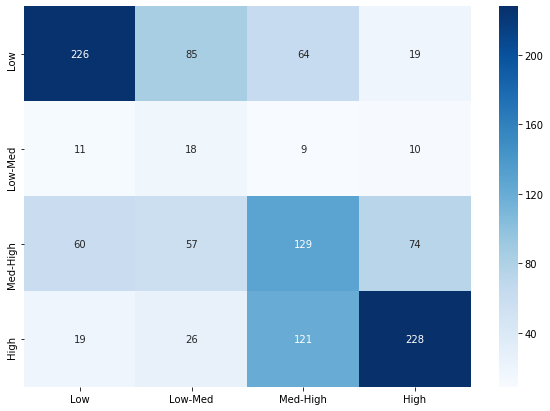

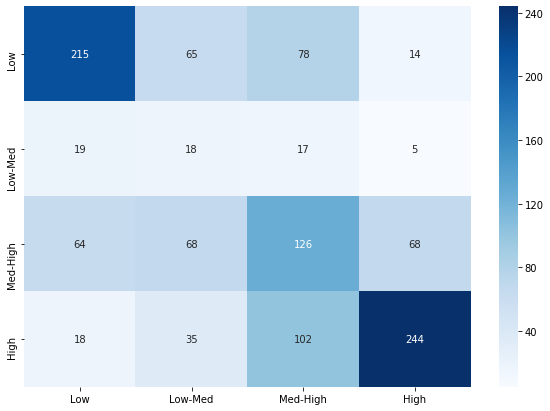

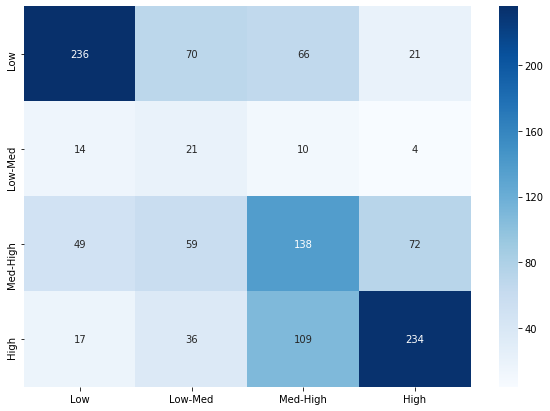

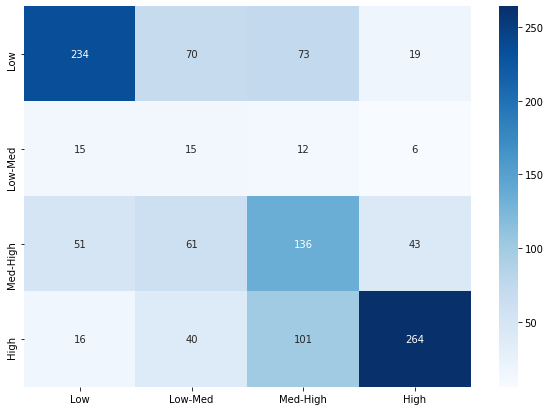

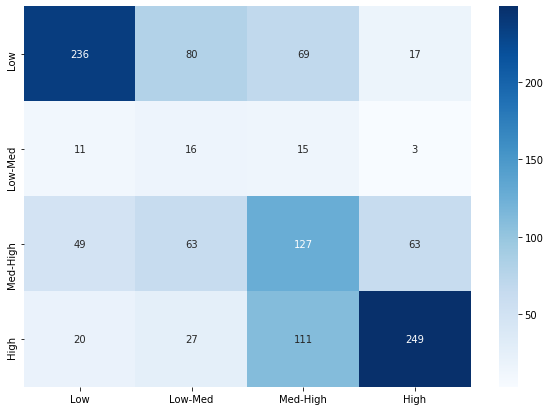

In [48]:
run_experiment(csv_path,get_relevant_columns(exp_dir), {0:0,1:1,2:2,3:3}, "")